In [1]:
import tensorflow as tf
from censai.models import VAE
import matplotlib.pyplot as plt
from argparse import Namespace
import os, json, glob
from censai.definitions import log_10
from matplotlib.ticker import FuncFormatter
from censai.data.kappa_tng import decode_train
from matplotlib.cm import ScalarMappable
from astropy.visualization import ImageNormalize, LogStretch
from censai.data.cosmos import decode_image, decode_shape, preprocess_image
import numpy as np
from pprint import pprint
from matplotlib.colors import LogNorm, SymLogNorm, CenteredNorm
import h5py

In [2]:
sample_size = 4

# Beluga

In [19]:
kap_path = os.path.join(os.getenv('CENSAI_PATH2'), "models", "VAE1_128hstfr_002_LS16_dr0.7_betaE0.2_betaDS5000_211115153537") # kappa VAE
# gal_path = os.path.join(os.getenv('CENSAI_PATH'), "models", "VAE1_COSMOSFR_003_F32_NLleaky_relu_LS32_betaE0.1_betaDS100000_211018104400") # cosmos vae
gal_path = os.path.join(os.getenv('CENSAI_PATH2'), "models", "VAE1_COSMOSFR_001_F16_NLleaky_relu_LS32_betaE0.1_betaDS100000_220112114306") # cosmos vae


with open(kap_path + "/script_params.json", "r") as f:
    kargs = json.load(f)
kargs = Namespace(**kargs)
with open(kap_path + "/model_hparams.json", "r") as f:
    hparams = json.load(f)
kvae = VAE(**hparams)
ckpt = tf.train.Checkpoint(net=kvae)
checkpoint_manager = tf.train.CheckpointManager(ckpt, kap_path, max_to_keep=1)
checkpoint_manager.checkpoint.restore(checkpoint_manager.latest_checkpoint).expect_partial()


with open(gal_path + "/script_params.json", "r") as f:
    gargs = json.load(f)
gargs = Namespace(**gargs)
with open(gal_path + "/model_hparams.json", "r") as f:
    hparams = json.load(f)
gvae = VAE(**hparams)
ckpt = tf.train.Checkpoint(net=gvae)
checkpoint_manager = tf.train.CheckpointManager(ckpt, gal_path, max_to_keep=1)
checkpoint_manager.checkpoint.restore(checkpoint_manager.latest_checkpoint).expect_partial()



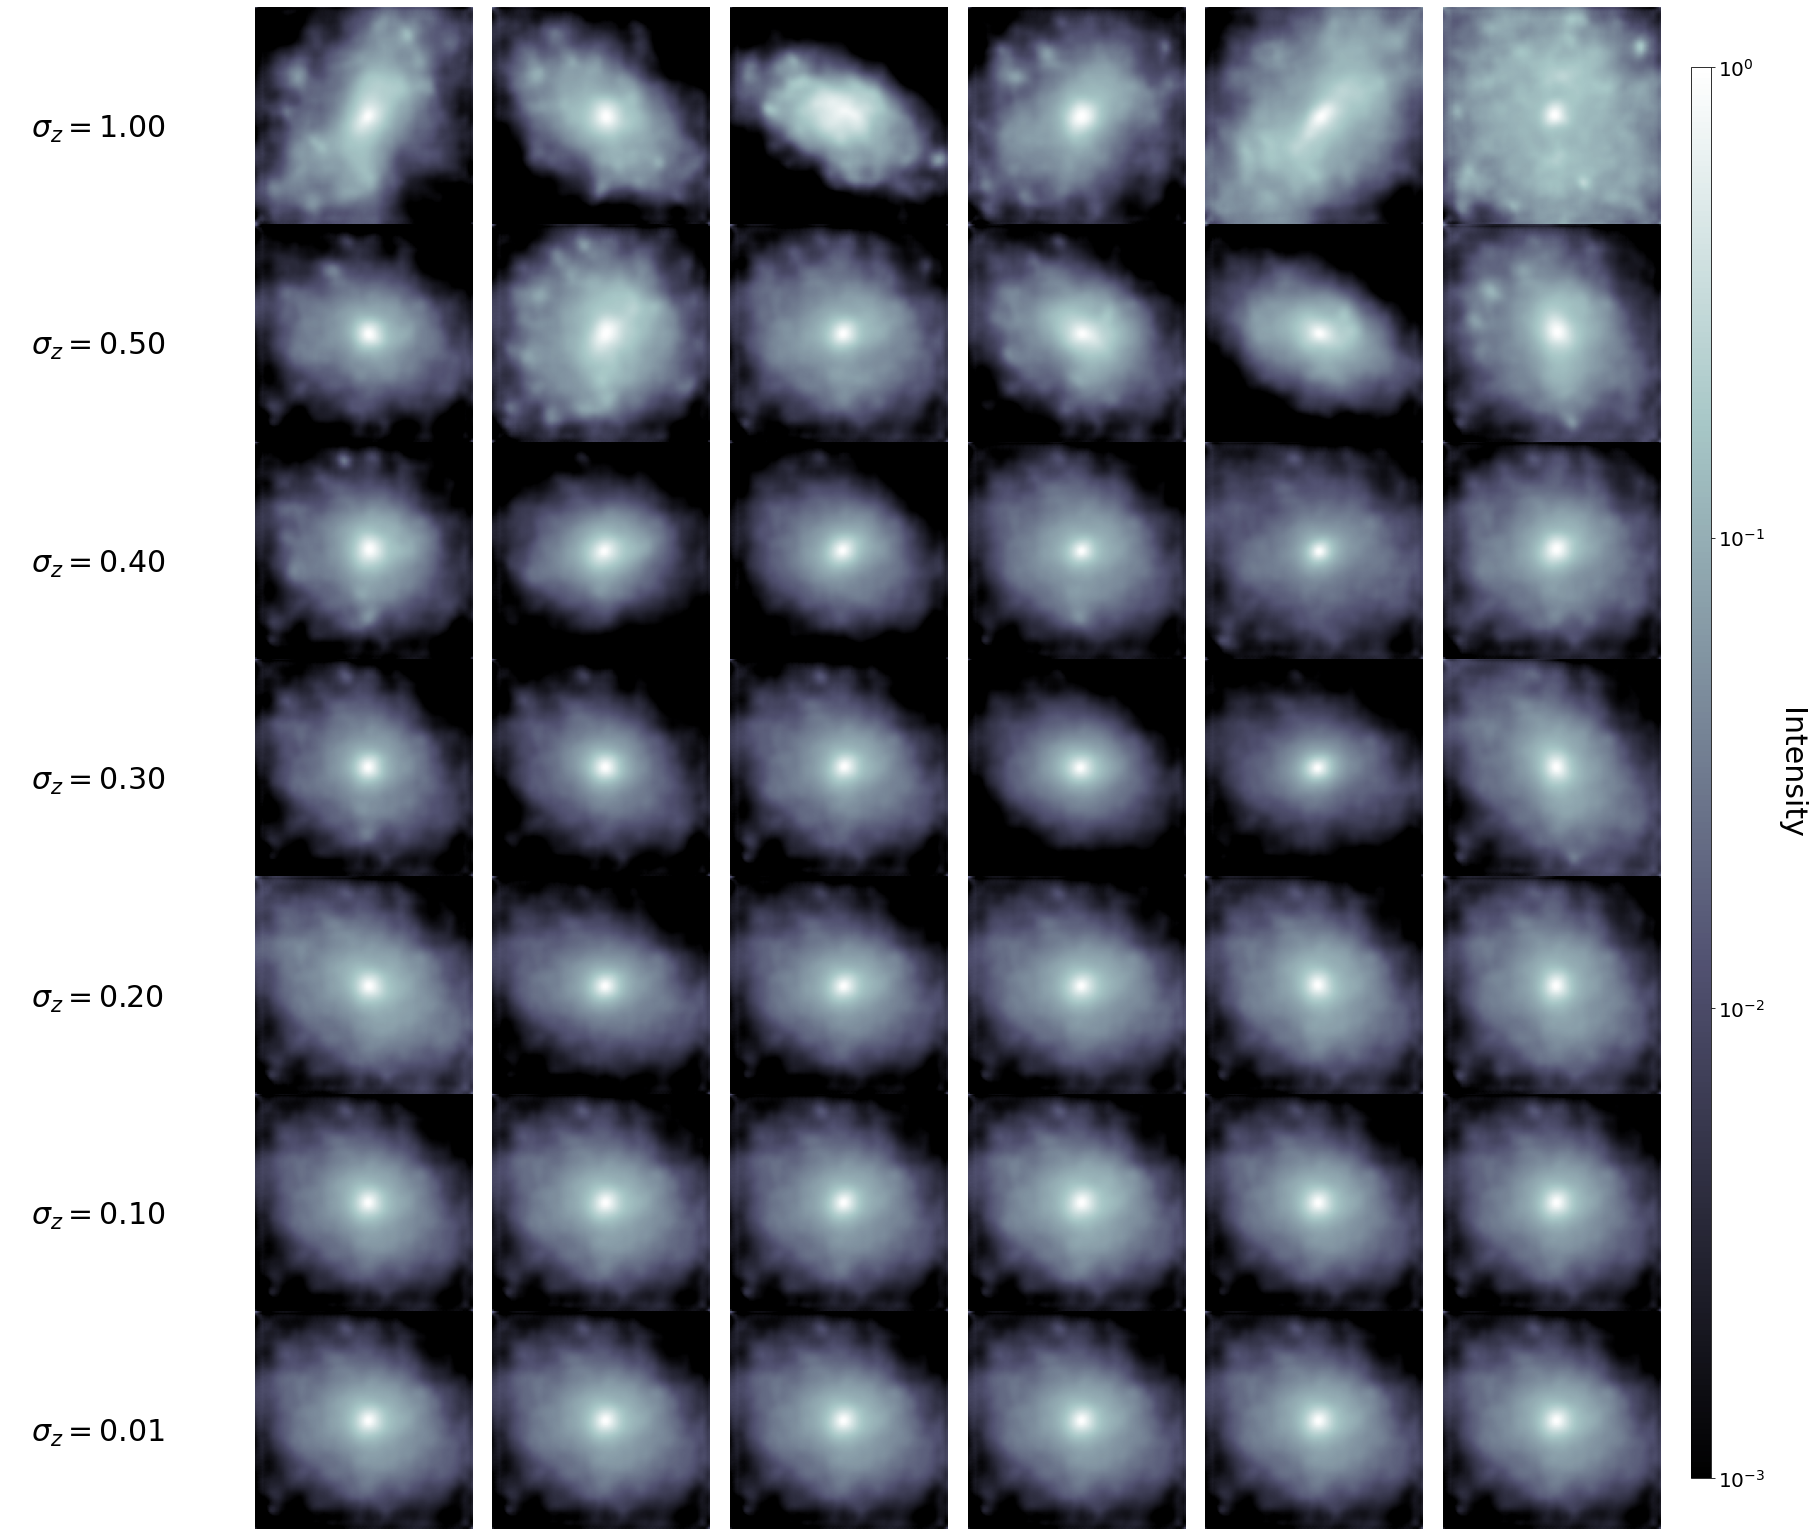

In [29]:

ball_size = [1, 0.5, 0.4, 0.3, 0.2, 0.1, 0.01]
mean = tf.random.normal(shape=(1, gvae.latent_size))

cmap = "bone"
fig, axs = plt.subplots(len(ball_size), 7, figsize=(4*7, 4*len(ball_size)))
for i, b in enumerate(ball_size):
    z = tf.random.normal(shape=(10, gvae.latent_size), mean=mean, stddev=b)
    sim_gal = gvae.decode(z)
    for j in range(6):
        axs[i, j+1].imshow(sim_gal[j, ..., 0], cmap=cmap, norm=ImageNormalize(stretch=LogStretch(), vmin=1e-3, vmax=1))
        axs[i, j+1].axis("off")
    axs[i, 0].axis("off")
    axs[i, 0].annotate(rf"$\sigma_z = ${b:.2f}", (0.1, 0.4), xycoords="axes fraction", fontsize=30)

        
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.15, 0.01, 0.7])
fig.colorbar(ScalarMappable(cmap=cmap, norm=ImageNormalize(stretch=LogStretch(), vmin=1e-3, vmax=1)), cax=cbar_ax, ticks=[0.001, 0.01, 0.1, 1.])
cbar_ax.set_yticklabels(["$10^{-3}$", "$10^{-2}$", "$10^{-1}$", "$10^{0}$"], fontsize=20) 
cbar_ax.set_ylabel(r"Intensity", rotation=270, labelpad=40, fontsize=30)
cbar_ax.yaxis.set_label_position("right")
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("gal_vae_region_sampling.png", facecolor="white")

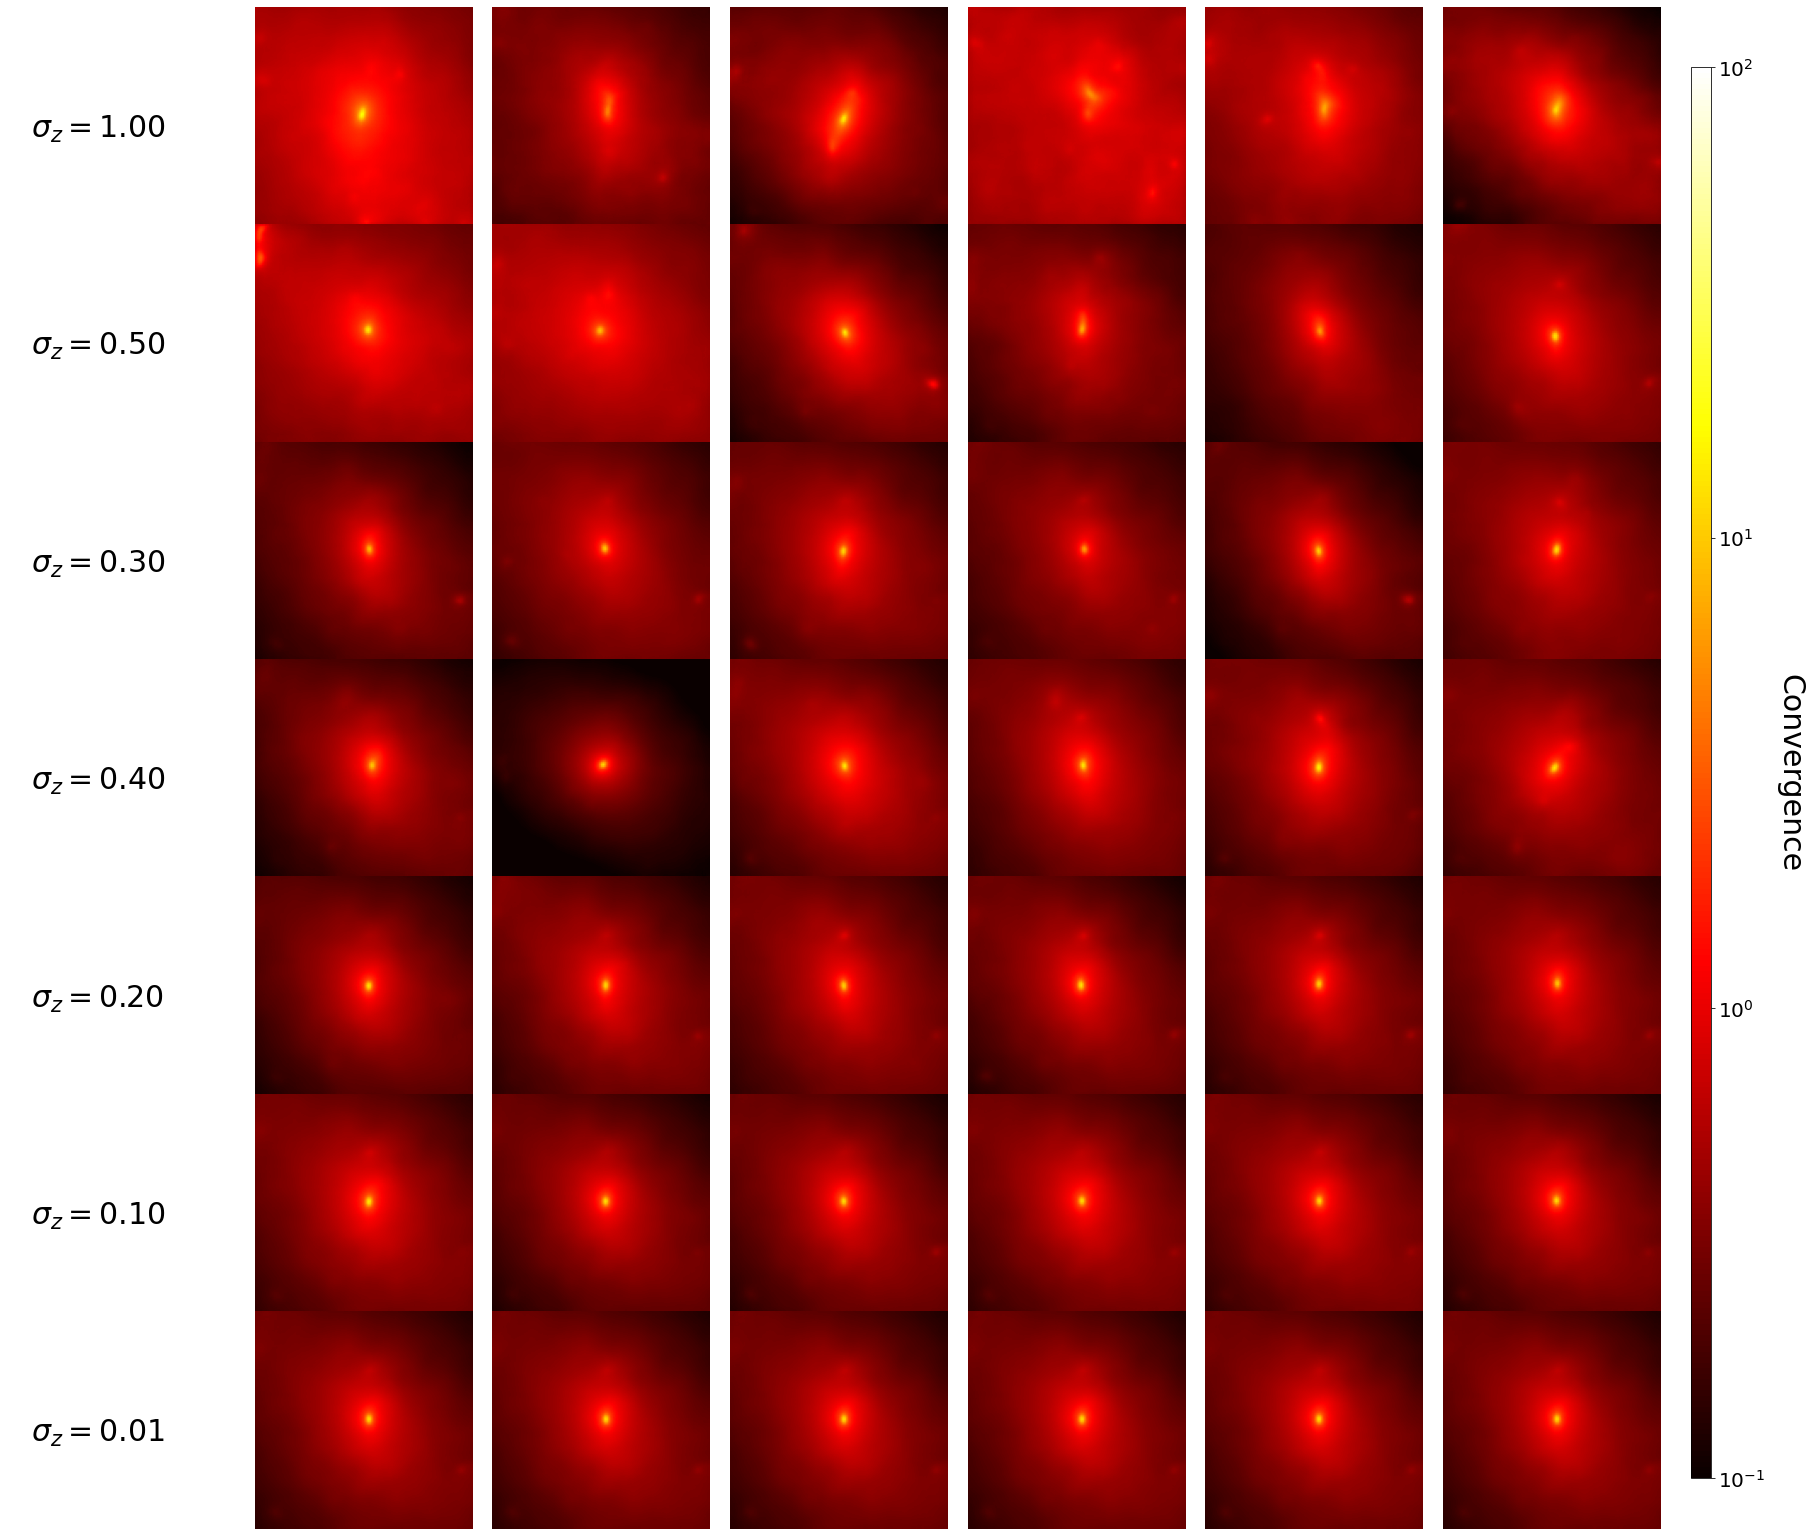

In [34]:

ball_size = [1, 0.5, 0.3, 0.4, 0.2, 0.1, 0.01]
mean = tf.random.normal(shape=(1, kvae.latent_size))

cmap = "hot"
fig, axs = plt.subplots(len(ball_size), 7, figsize=(4*7, 4*len(ball_size)))
for i, b in enumerate(ball_size):
    z = tf.random.normal(shape=(10, kvae.latent_size), mean=mean, stddev=b)
    sim_kap = kvae.decode(z)
    for j in range(6):
        axs[i, j+1].imshow(10**sim_kap[j, ..., 0], cmap=cmap, norm=ImageNormalize(stretch=LogStretch(), vmin=1e-1, vmax=100))
        axs[i, j+1].axis("off")
    axs[i, 0].axis("off")
    axs[i, 0].annotate(rf"$\sigma_z = ${b:.2f}", (0.1, 0.4), xycoords="axes fraction", fontsize=30)

        
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.15, 0.01, 0.7])
fig.colorbar(ScalarMappable(cmap=cmap, norm=ImageNormalize(stretch=LogStretch(), vmin=1e-1, vmax=100)), cax=cbar_ax, ticks=[0.1, 1, 10, 100])
cbar_ax.set_yticklabels(["$10^{-1}$", "$10^{0}$", "$10^{1}$", "$10^{2}$"], fontsize=20) 
cbar_ax.set_ylabel(r"Convergence", rotation=270, labelpad=40, fontsize=30)
cbar_ax.yaxis.set_label_position("right")
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("kap_vae_region_sampling.png", facecolor="white")

In [ ]:
files = []
for dataset in kargs.datasets:
    files.extend(glob.glob(os.path.join(dataset, "*.tfrecords")))
np.random.shuffle(files)
# Read concurrently from multiple records
files = tf.data.Dataset.from_tensor_slices(files)
kap_dataset = files.interleave(lambda x: tf.data.TFRecordDataset(x, compression_type=kargs.compression_type), block_length=kargs.block_length, num_parallel_calls=tf.data.AUTOTUNE)
kap_dataset = kap_dataset.map(decode_train).batch(sample_size)

files = []
for dataset in gargs.datasets:
    files.extend(glob.glob(os.path.join(dataset, "*.tfrecords")))
np.random.shuffle(files)
# Read concurrently from multiple records
files = tf.data.Dataset.from_tensor_slices(files)
dataset = files.interleave(lambda x: tf.data.TFRecordDataset(x, compression_type=gargs.compression_type),block_length=gargs.block_length, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.map(decode_image).map(preprocess_image).batch(sample_size)

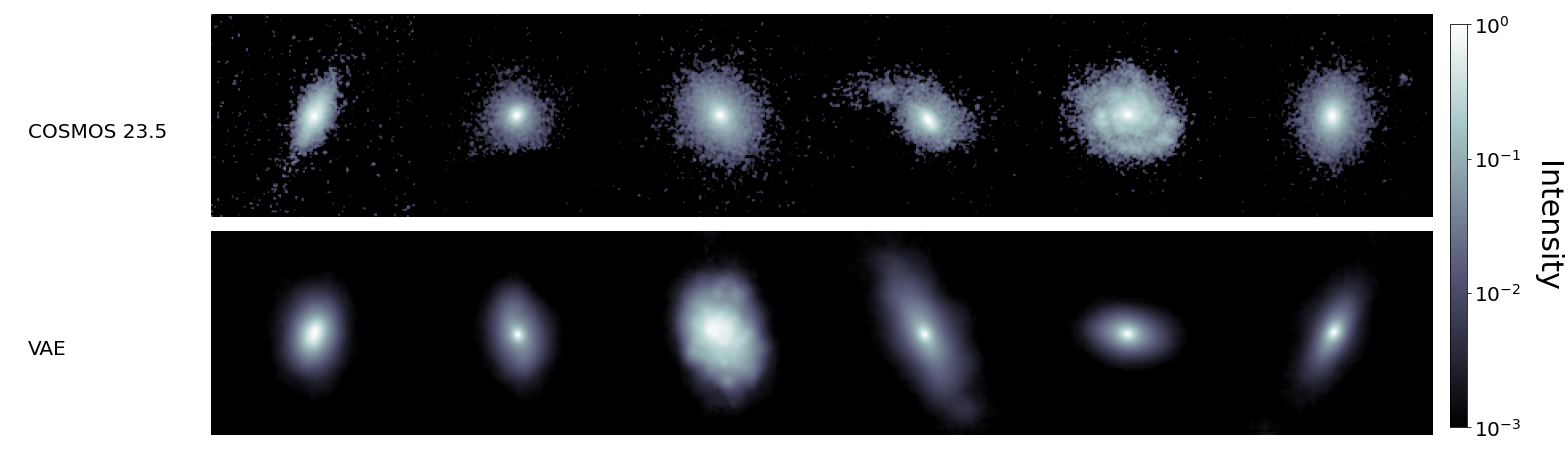

In [114]:
cmap = "bone"
fig, axs = plt.subplots(2, 7, figsize=(24, 8))
for gal in dataset:
    break
sim_gal = preprocess_image(10**gvae.sample(sample_size))
with h5py.File("gal_vae_samples.h5", 'w') as hf:
    hf["cosmos"] = gal.numpy().squeeze().astype(np.float32)
    hf["vae"] = sim_gal.numpy().squeeze().astype(np.float32)

for j in range(6):
    axs[0, j+1].imshow(gal[j, ..., 0], cmap=cmap, norm=ImageNormalize(stretch=LogStretch(), vmin=1e-3, vmax=1))
    axs[0, j+1].axis("off")
for j in range(6):
    axs[1, j+1].imshow(sim_gal[j, ..., 0], cmap=cmap, norm=ImageNormalize(stretch=LogStretch(), vmin=1e-3, vmax=1))
    axs[1, j+1].axis("off")
axs[0, 0].axis("off")
axs[0, 0].annotate("COSMOS 23.5", (0.1, 0.4), xycoords="axes fraction", fontsize=20)
axs[1, 0].axis("off")
axs[1, 0].annotate("VAE", (0.1, 0.4), xycoords="axes fraction", fontsize=20)

fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.15, 0.01, 0.7])
fig.colorbar(ScalarMappable(cmap=cmap, norm=ImageNormalize(stretch=LogStretch(), vmin=1e-3, vmax=1)), cax=cbar_ax, ticks=[0.001, 0.01, 0.1, 1.])
cbar_ax.set_yticklabels(["$10^{-3}$", "$10^{-2}$", "$10^{-1}$", "$10^{0}$"], fontsize=20) 
cbar_ax.set_ylabel(r"Intensity", rotation=270, labelpad=40, fontsize=30)
cbar_ax.yaxis.set_label_position("right")
plt.subplots_adjust(wspace=0, hspace=0)

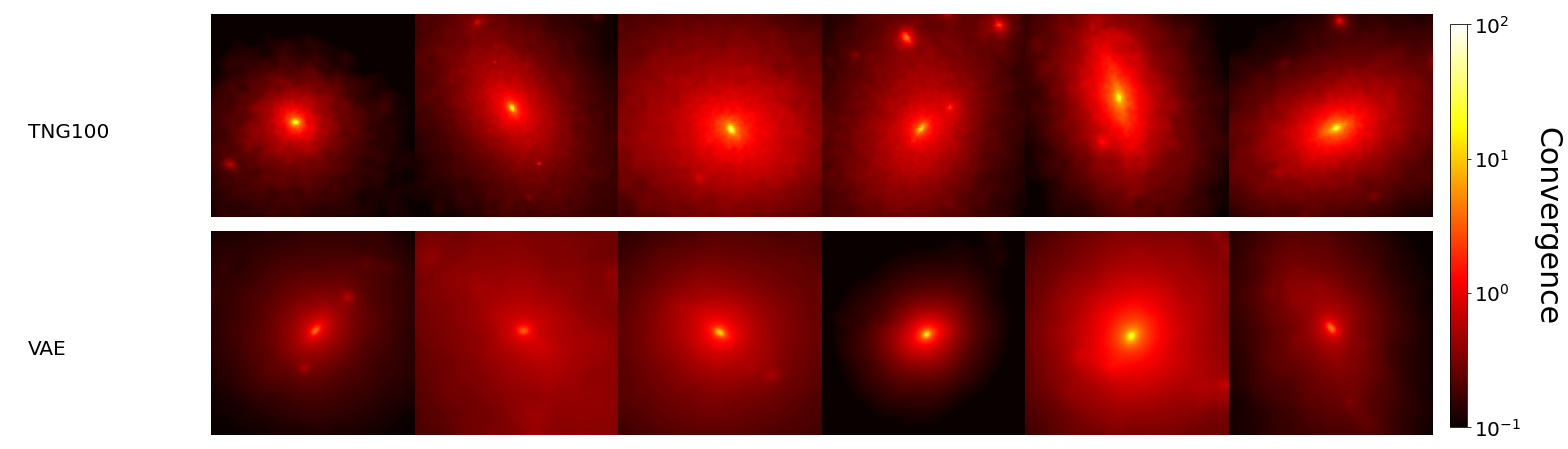

In [119]:
cmap = "hot"
fig, axs = plt.subplots(2, 7, figsize=(24, 8))
for kap in kap_dataset:
    break
sim_kap = 10**kvae.sample(sample_size)
with h5py.File("kap_vae_samples.h5", 'w') as hf:
    hf["tng"] = kap.numpy().squeeze().astype(np.float32)
    hf["vae"] = sim_gal.numpy().squeeze().astype(np.float32)

for j in range(6):
    axs[0, j+1].imshow(kap[j, ..., 0], cmap=cmap, norm=ImageNormalize(stretch=LogStretch(), vmin=1e-1, vmax=100))
    axs[0, j+1].axis("off")
for j in range(6):
    axs[1, j+1].imshow(sim_kap[j, ..., 0], cmap=cmap, norm=ImageNormalize(stretch=LogStretch(), vmin=1e-1, vmax=100))
    axs[1, j+1].axis("off")
axs[0, 0].axis("off")
axs[0, 0].annotate("TNG100", (0.1, 0.4), xycoords="axes fraction", fontsize=20)
axs[1, 0].axis("off")
axs[1, 0].annotate("VAE", (0.1, 0.4), xycoords="axes fraction", fontsize=20)

fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.15, 0.01, 0.7])
fig.colorbar(ScalarMappable(cmap=cmap, norm=ImageNormalize(stretch=LogStretch(), vmin=1e-1, vmax=100)), cax=cbar_ax, ticks=[0.1, 1, 10, 100])
cbar_ax.set_yticklabels(["$10^{-1}$", "$10^{0}$", "$10^{1}$", "$10^{2}$"], fontsize=20) 
cbar_ax.set_ylabel(r"Convergence", rotation=270, labelpad=40, fontsize=30)
cbar_ax.yaxis.set_label_position("right")
plt.subplots_adjust(wspace=0, hspace=0)

# Laptop

In [3]:
plt.style.use("science")

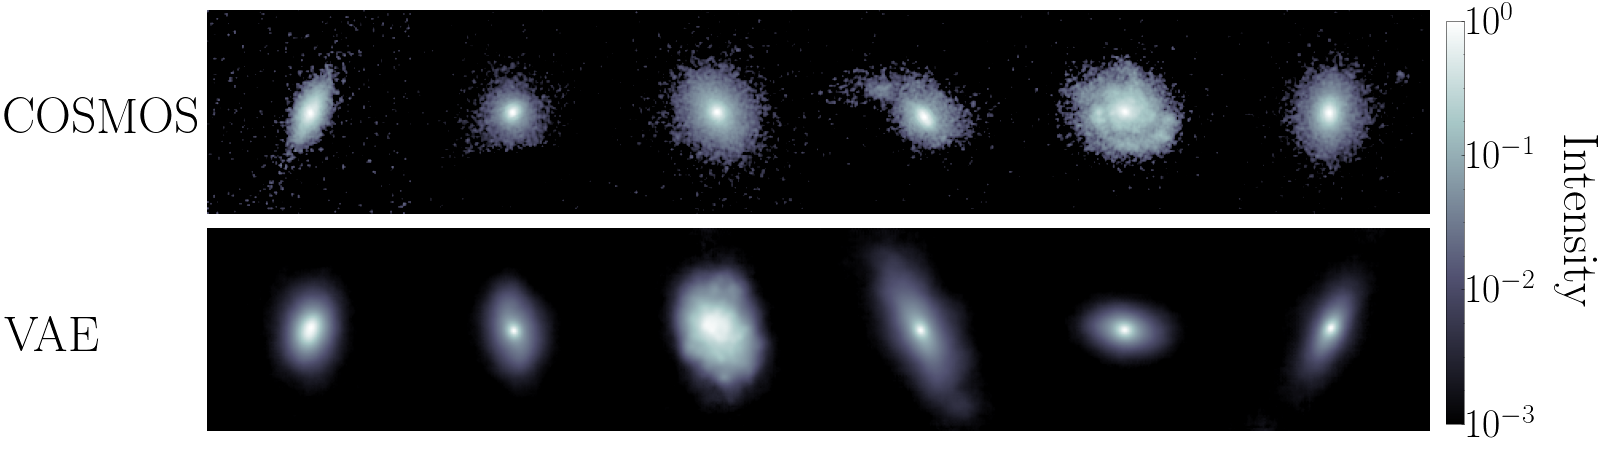

In [6]:
hf = h5py.File("gal_vae_samples.h5", 'r')
gal = hf["cosmos"]
sim_gal = hf["vae"]

cmap = "bone"
fig, axs = plt.subplots(2, 7, figsize=(24, 8))
start = 0
for j in range(6):
    axs[0, j+1].imshow(gal[j+start, ...], cmap=cmap, norm=ImageNormalize(stretch=LogStretch(), vmin=1e-3, vmax=1))
    axs[0, j+1].axis("off")
for j in range(6):
    axs[1, j+1].imshow(sim_gal[j+start, ...], cmap=cmap, norm=ImageNormalize(stretch=LogStretch(), vmin=1e-3, vmax=1))
    axs[1, j+1].axis("off")
axs[0, 0].axis("off")
axs[0, 0].annotate("COSMOS 23.5", (0, 0.4), xycoords="axes fraction", fontsize=50)
axs[1, 0].axis("off")
axs[1, 0].annotate("VAE", (0, 0.4), xycoords="axes fraction", fontsize=50)

fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.15, 0.01, 0.7])
fig.colorbar(ScalarMappable(cmap=cmap, norm=ImageNormalize(stretch=LogStretch(), vmin=1e-3, vmax=1)), cax=cbar_ax, ticks=[0.001, 0.01, 0.1, 1.])
cbar_ax.set_yticklabels(["$10^{-3}$", "$10^{-2}$", "$10^{-1}$", "$10^{0}$"], fontsize=40) 
cbar_ax.set_ylabel(r"Intensity", rotation=270, labelpad=60, fontsize=50)
cbar_ax.yaxis.set_label_position("right")
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("gal_vae_sample.png")

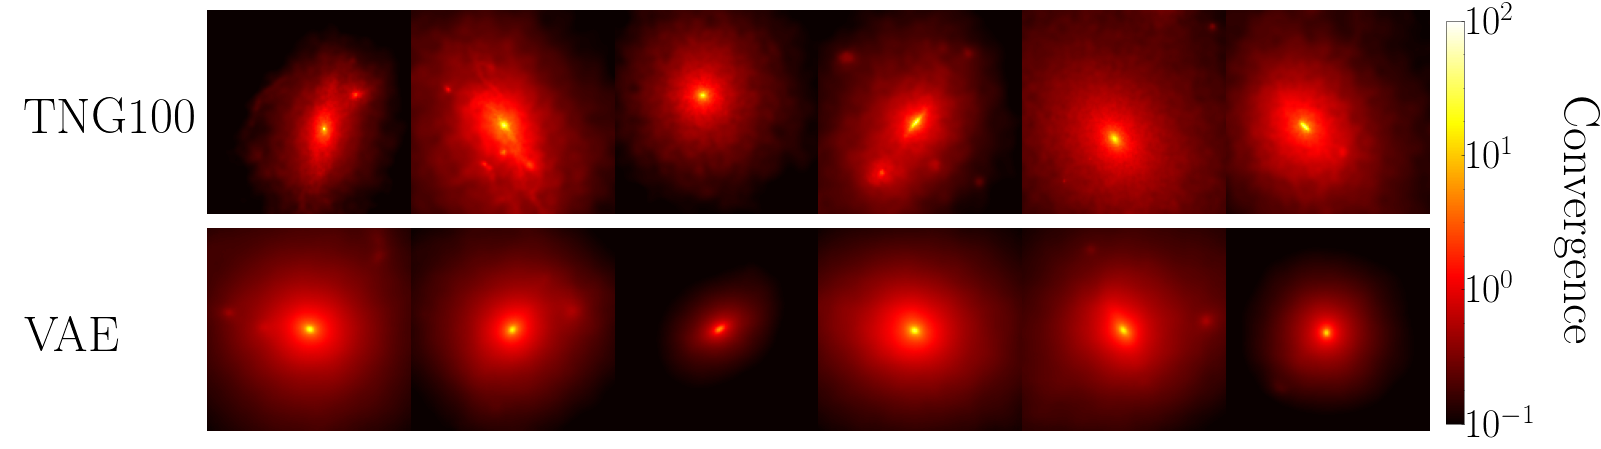

In [7]:
cmap = "hot"
fig, axs = plt.subplots(2, 7, figsize=(24, 8))

hf = h5py.File("kap_vae_samples.h5", 'r')
kap = hf["tng"]
sim_kap = hf["vae"]
start = 6
for j in range(6):
    axs[0, j+1].imshow(kap[j+start, ...], cmap=cmap, norm=ImageNormalize(stretch=LogStretch(), vmin=1e-1, vmax=100))
    axs[0, j+1].axis("off")
for j in range(6):
    axs[1, j+1].imshow(sim_kap[j+start, ...], cmap=cmap, norm=ImageNormalize(stretch=LogStretch(), vmin=1e-1, vmax=100))
    axs[1, j+1].axis("off")
axs[0, 0].axis("off")
axs[0, 0].annotate("TNG100", (0.1, 0.4), xycoords="axes fraction", fontsize=50)
axs[1, 0].axis("off")
axs[1, 0].annotate("VAE", (0.1, 0.4), xycoords="axes fraction", fontsize=50)

fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.15, 0.01, 0.7])
fig.colorbar(ScalarMappable(cmap=cmap, norm=ImageNormalize(stretch=LogStretch(), vmin=1e-1, vmax=100)), cax=cbar_ax, ticks=[0.1, 1, 10, 100])
cbar_ax.set_yticklabels(["$10^{-1}$", "$10^{0}$", "$10^{1}$", "$10^{2}$"], fontsize=40) 
cbar_ax.set_ylabel(r"Convergence", rotation=270, labelpad=60, fontsize=50)
cbar_ax.yaxis.set_label_position("right")
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("kap_vae_sample.png")